In [0]:
%pip install vaderSentiment textblob nltk
%pip install datasets
%pip install transformers
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
%pip install tensorflow
%pip install praw
%pip install tf-keras
%pip install gensim spacy nltk wordcloud
%pip install spacy
%pip install inflect
%pip install nltk
!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_md

  Obtaining dependency information for vaderSentiment from https://files.pythonhosted.org/packages/76/fc/310e16254683c1ed35eeb97386986d6c00bc29df17ce280aed64d55537e9/vaderSentiment-3.3.2-py2.py3-none-any.whl.metadata
  Using cached vaderSentiment-3.3.2-py2.py3-none-any.whl.metadata (572 bytes)
  Obtaining dependency information for textblob from https://files.pythonhosted.org/packages/1e/d6/40aa5aead775582ea0cf35870e5a3f16fab4b967f1ad2debe675f673f923/textblob-0.19.0-py3-none-any.whl.metadata
  Using cached textblob-0.19.0-py3-none-any.whl.metadata (4.4 kB)
  Obtaining dependency information for nltk from https://files.pythonhosted.org/packages/4d/66/7d9e26593edda06e8cb531874633f7c2372279c3b0f46235539fe546df8b/nltk-3.9.1-py3-none-any.whl.metadata
  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Obtaining dependency information for regex>=2021.8.3 from https://files.pythonhosted.org/packages/ee/2e/c689f274a92deffa03999a430505ff2aeace408fd681a90eafa92fdd6930/regex-2025.7.34-

In [0]:
pip install youtube-comment-downloader

  Obtaining dependency information for youtube-comment-downloader from https://files.pythonhosted.org/packages/b3/33/d6604b171d9c1d15ef00f71ebdcf29c54108b18c7848083cccc72feb3473/youtube_comment_downloader-0.1.76-py3-none-any.whl.metadata
  Obtaining dependency information for dateparser from https://files.pythonhosted.org/packages/87/22/f020c047ae1346613db9322638186468238bcfa8849b4668a22b97faad65/dateparser-1.2.2-py3-none-any.whl.metadata
  Obtaining dependency information for pytz>=2024.2 from https://files.pythonhosted.org/packages/81/c4/34e93fe5f5429d7570ec1fa436f1986fb1f00c3e0f43a589fe2bbcd22c3f/pytz-2025.2-py2.py3-none-any.whl.metadata
  Obtaining dependency information for tzlocal>=0.2 from https://files.pythonhosted.org/packages/c2/14/e2a54fabd4f08cd7af1c07030603c3356b74da07f7cc056e600436edfa17/tzlocal-5.3.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/315.5 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━ 307.2/315.5 kB 10.0 MB/s eta 0:0

In [0]:
from youtube_comment_downloader import YoutubeCommentDownloader
import pandas as pd

downloader = YoutubeCommentDownloader()

urls = [
    'https://www.youtube.com/watch?v=8r6FyCMbqow',
    'https://www.youtube.com/watch?v=oPD3KR_PtfY',
    'https://www.youtube.com/watch?v=QrCqsYqbuAc',
    'https://www.youtube.com/watch?v=-Wr-RuoV0pU&ab_channel=BALR',
    'https://www.youtube.com/watch?v=nHj8LrOmAgE&ab_channel=ChrisWilliamson',
    'https://www.youtube.com/watch?v=mKs0Uyj0q-w&ab_channel=HowMoneyWorks',
    'https://www.youtube.com/watch?v=mKs0Uyj0q-w&ab_channel=HowMoneyWorks'
]

comment_list = []
for url in urls:
    comments = downloader.get_comments_from_url(url)
    for comment in comments:
        comment_list.append(comment)

df = pd.DataFrame(comment_list)

df = df[['text', 'votes']]

In [0]:
spark_df = spark.createDataFrame(df)
spark_df.createOrReplaceTempView("youtube_comments")

In [0]:
youtube_comments_df = df

## Topic Modelling

In [0]:
import nltk
nltk.download('wordnet')

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
import numpy as np
import pandas as pd
import inflect
import gensim
import matplotlib.pyplot as plt
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import inflect
from gensim.utils import simple_preprocess
from wordcloud import STOPWORDS as wc_stopwords
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess

In [0]:
# Define additional stopwords
custom_stopwords = set(STOPWORDS).union({
    "uk","like","would","also","getting","got","get","go",
    "ll","ve","re","don","didn","isn","wasn","weren","day",
    "now","ask","want","know","think","say","said","saying","says","bn","email",
    "new","year","person","people","try","look","tell","thing","good","use","will",
    "see","back","come","one","really","i_am","i_don","take","put",
    "the_uk","feel","make","today","still","m_not","due_to","even", "wa", "thi", "ha",
    "seem", "we_re", "do_you", "etc", "https_www", "hi", "let", "would_be",
    "we_re", "hi", "do_you", "seem", "etc", "would_be"
})

# Initialize lemmatizer and inflect engine
lemmatizer = WordNetLemmatizer()
p = inflect.engine()

# Step 1: Train the bigram model on total_text
sentences = youtube_comments_df["text"].astype(str).apply(lambda x: x.split())  # Convert strings to tokenized lists
bigram = Phrases(sentences, min_count=5, threshold=10)
bigram_model = Phraser(bigram)

# Step 2: Apply the bigram model to create bigram-enhanced text
youtube_comments_df["bigram_text"] = youtube_comments_df["text"].apply(lambda x: " ".join(bigram_model[x.split()]))

# Step 3: Preprocess bigram-enhanced text
def preprocess(text):
    tokens = simple_preprocess(text)  # Tokenize
    cleaned_tokens = [
        lemmatizer.lemmatize(
            lemmatizer.lemmatize(p.singular_noun(token) or token, 'n'),  # Normalize nouns
            'v'  # Normalize verbs
        )
        for token in tokens if token not in custom_stopwords  # Remove stopwords
    ]
    return cleaned_tokens



In [0]:
youtube_comments_df["processed_text_new"] = youtube_comments_df["bigram_text"].apply(preprocess)


In [0]:
%python

# Create dictionary and corpus for Reddit posts
post_dictionary = corpora.Dictionary(youtube_comments_df["processed_text_new"])
post_corpus = [post_dictionary.doc2bow(text) for text in youtube_comments_df["processed_text_new"]]


# Train LDA model for Reddit posts
lda_model_posts = gensim.models.LdaModel(
    corpus=post_corpus,
    id2word=post_dictionary,
    num_topics=5,  # Adjust number of topics as needed
    random_state=42,
    passes=10
)


# Display top topics for Reddit posts
print("\n🔹 Top Topics in Reddit Comments:")
for idx, topic in lda_model_posts.print_topics(-1):
    print(f"Topic {idx}: {topic}")



🔹 Top Topics in Reddit Comments:
Topic 0: 0.017*"tax" + 0.011*"money" + 0.010*"pay" + 0.009*"government" + 0.009*"rich" + 0.007*"police" + 0.007*"work" + 0.006*"wealth" + 0.006*"country" + 0.005*"job"
Topic 1: 0.011*"starmer" + 0.011*"brexit" + 0.010*"busines" + 0.008*"rich_person" + 0.006*"capitalism" + 0.006*"clas" + 0.006*"right" + 0.006*"import" + 0.005*"drive" + 0.004*"word"
Topic 2: 0.017*"me" + 0.007*"move" + 0.006*"trump" + 0.006*"go" + 0.006*"american" + 0.006*"germany" + 0.006*"empire" + 0.006*"america" + 0.006*"usa" + 0.005*"brit"
Topic 3: 0.012*"government" + 0.010*"population" + 0.008*"immigration" + 0.007*"market" + 0.007*"law" + 0.006*"labour" + 0.006*"policy" + 0.006*"problem" + 0.006*"britain" + 0.006*"immigrant"
Topic 4: 0.024*"country" + 0.013*"london" + 0.010*"leave" + 0.009*"me" + 0.007*"world" + 0.007*"go" + 0.007*"live" + 0.006*"city" + 0.006*"life" + 0.005*"move"


In [0]:
spark_youcom = spark.createDataFrame(youtube_comments_df)
spark_youcom.createOrReplaceTempView("youtube_coms")
top_comms = spark.sql("""SELECT * FROM youtube_coms ORDER BY CAST(votes AS INT) DESC LIMIT 1000""")
top_comms_df = top_comms.toPandas()

In [0]:

# Build a cleaner custom stopword set (deduped)
custom_stopwords = set(wc_stopwords).union({
    "uk","like","would","also","getting","got","get","go",
    "ll","ve","re","don","didn","isn","wasn","weren","day",
    "now","ask","want","know","think","say","said","saying","says","bn","email",
    "new","year","person","people","try","look","tell","thing","good","use","will",
    "see","back","come","one","really","i_am","i_don","take","put",
    "the_uk","feel","make","today","still","m_not","due_to","even", "wa", "thi", "ha",
    "seem", "we_re", "do_you", "etc", "https_www", "hi", "let", "would_be",
    "we_re", "hi", "do_you", "seem", "etc", "would_be", "bro", "if_you", "lol", "me", "im",
    "I"
})

lemmatizer = WordNetLemmatizer()
p = inflect.engine()

# Train bigrams on LOWER-CASED, tokenized text (better quality than .split())
sentences = top_comms_df["text"].astype(str).apply(lambda x: simple_preprocess(x))
bigram = Phrases(sentences, min_count=5, threshold=10)
bigram_model = Phraser(bigram)

# Apply bigrams
top_comms_df["bigram_text"] = sentences.apply(lambda toks: " ".join(bigram_model[toks]))

def preprocess(text: str):
    tokens = simple_preprocess(text)  # lower, deaccent, min_len=2 by default
    cleaned = []
    for t in tokens:
        # normalize first
        t_norm = p.singular_noun(t) or t      # persons/people -> person (when applicable)
        t_norm = lemmatizer.lemmatize(t_norm, 'n')
        t_norm = lemmatizer.lemmatize(t_norm, 'v')
        # THEN filter
        if t_norm not in custom_stopwords:
            cleaned.append(t_norm)
    return cleaned

top_comms_df["processed_text_new"] = top_comms_df["bigram_text"].apply(preprocess)


Running LDA sweep...
k= 4  Cv=0.361  UMass=-4.361  Perplexity=201.1
k= 5  Cv=0.328  UMass=-5.204  Perplexity=210.7
k= 6  Cv=0.352  UMass=-5.797  Perplexity=216.4
k= 7  Cv=0.348  UMass=-5.766  Perplexity=223.5
k= 8  Cv=0.374  UMass=-5.766  Perplexity=229.4
k= 9  Cv=0.355  UMass=-6.096  Perplexity=234.8
k=10  Cv=0.356  UMass=-6.578  Perplexity=241.4
k=11  Cv=0.300  UMass=-6.303  Perplexity=245.1
k=12  Cv=0.330  UMass=-6.443  Perplexity=251.1


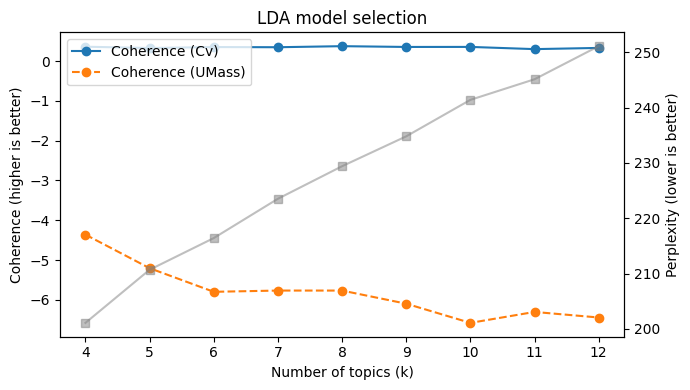


Suggested k by Cv peak: 8

Final model (k=8) overall coherence Cv = 0.374
 topic_id                                                   top_terms prevalence coherence_Cv
        7               leave, weed, shit, state, move, go, me, right      0.149        0.438
        4    drive, state, police, smoke, leave, lose, thailand, wish      0.148        0.488
        2              me, country, go, leave, live, best, time, weed      0.138        0.400
        3      move, america, place, make, worse, me, country, better      0.133        0.318
        1 drive, leave, bad, america, prescription, country, true, me      0.131        0.352
        0          police, move, never, place, live, draw, weed, shit      0.121        0.357
        6  smoke, weed, much, leave, police, germany, system, country      0.104        0.302
        5       dont, thailand, great, hear, state, usa, koh, welcome      0.075        0.340


In [0]:
%python
texts = top_comms_df["processed_text_new"]         # tokenized, preprocessed list-of-lists
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(t) for t in texts]

K_RANGE = range(4, 13)   
RANDOM_STATE = 42
PASSES = 10             
ALPHA = 'symmetric'      
ETA = 'symmetric'

def fit_lda(k):
    model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=k,
        random_state=RANDOM_STATE,
        passes=PASSES,
        alpha=ALPHA,
        eta=ETA,
        minimum_probability=0.0
    )
    perplexity = np.exp2(-model.log_perplexity(corpus))
    cm_cv = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    cv = cm_cv.get_coherence()
    cm_umass = CoherenceModel(model=model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    umass = cm_umass.get_coherence()
    return model, cv, umass, perplexity

results = []
models = {}

print("Running LDA sweep...")
for k in K_RANGE:
    mdl, cv, umass, pplx = fit_lda(k)
    models[k] = mdl
    results.append({"k": k, "coherence_cv": cv, "coherence_umass": umass, "perplexity": pplx})
    print(f"k={k:>2}  Cv={cv:.3f}  UMass={umass:.3f}  Perplexity={pplx:.1f}")

res_df = pd.DataFrame(results)

fig, ax1 = plt.subplots(figsize=(7,4))
ax1.plot(res_df["k"], res_df["coherence_cv"], marker="o", label="Coherence (Cv)")
ax1.plot(res_df["k"], res_df["coherence_umass"], marker="o", linestyle="--", label="Coherence (UMass)")
ax1.set_xlabel("Number of topics (k)")
ax1.set_ylabel("Coherence (higher is better)")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(res_df["k"], res_df["perplexity"], marker="s", color="gray", alpha=0.5, label="Perplexity")
ax2.set_ylabel("Perplexity (lower is better)")
plt.title("LDA model selection")
plt.tight_layout()
plt.show()

best_k = int(res_df.loc[res_df["coherence_cv"].idxmax(), "k"])
print(f"\nSuggested k by Cv peak: {best_k}")

final_model = models[best_k]  # reuse trained model at best_k

# Topic prevalence (mean theta across docs)
doc_topic = np.array([
    [p for _, p in final_model.get_document_topics(bow, minimum_probability=0.0)]
    for bow in corpus
])
prevalence = doc_topic.mean(axis=0)

# Coherence per topic
cm_final = CoherenceModel(model=final_model, texts=texts, dictionary=dictionary, coherence='c_v')
coh_per_topic = cm_final.get_coherence_per_topic()
overall_cv = cm_final.get_coherence()

# Build a tidy table
def top_terms(model, topic_id, topn=8):
    return ", ".join([w for w, _ in model.show_topic(topic_id, topn=topn)])

summary = pd.DataFrame({
    "topic_id": range(best_k),
    "top_terms": [top_terms(final_model, k, topn=8) for k in range(best_k)],
    "prevalence": [prevalence[k] for k in range(best_k)],
    "coherence_Cv": coh_per_topic
}).sort_values("prevalence", ascending=False).reset_index(drop=True)

summary["prevalence"] = summary["prevalence"].map(lambda x: f"{x:.3f}")
summary["coherence_Cv"] = summary["coherence_Cv"].map(lambda x: f"{x:.3f}")

print(f"\nFinal model (k={best_k}) overall coherence Cv = {overall_cv:.3f}")
print(summary.to_string(index=False))
